## Case Study - Cross Domain Sentiment Analysis (Books to Kitchen Appliances) sentiment transfer learning

John Blitzer, Mark Dredze, Fernando Pereira. Biographies, Bollywood, Boom-boxes and Blenders: Domain Adaptation for Sentiment Classification. Association of Computational Linguistics (ACL), 2007.
The Multi-Domain Sentiment Dataset contains product reviews taken from Amazon.com from 4 product types (domains): Kitchen, Books, DVDs, and Electronics. Each domain has several thousand reviews, but the exact number varies by domain.


<img src="attachment:Book-Kitchen.png" width="600", height="400">

In [1]:
#import packages and verify versions

# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# nltk
import nltk
print('nltk: %s' % nltk.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)
# wordcloud
import wordcloud
print('wordcloud: %s' % wordcloud.__version__)
# keras
import keras
print('keras: %s' % keras.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)

numpy: 1.15.4
scipy: 0.19.1
matplotlib: 2.1.0
pandas: 0.20.3
nltk: 3.2.4
sklearn: 0.19.1
wordcloud: 1.4.1


/Users/udaykamath/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


keras: 2.2.4
tensorflow: 1.12.0


In [2]:
# Basic packages
import pandas as pd
import numpy as np
import re
import collections
import time
import matplotlib.pyplot as plt


# Packages for data preparation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix
import itertools

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

# Word cloud visualization libraries
from scipy.misc import imresize
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from collections import Counter

from keras.wrappers.scikit_learn import KerasClassifier

# Packages for Keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, UpSampling1D, Dense, Dropout, AlphaDropout, ThresholdedReLU, Convolution1D, ZeroPadding1D, Activation, MaxPooling1D, SpatialDropout1D, Input
from keras.layers import GlobalMaxPooling1D, concatenate, LSTM, Bidirectional, BatchNormalization, Concatenate, Dot, Multiply, RepeatVector
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers import Bidirectional, TimeDistributed
from keras.layers.core import Reshape, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.constraints import maxnorm
from keras.regularizers import l2

# data preprocessing
import xml.etree.ElementTree as ET

## GLOBAL VARIABLES

In [3]:
# parameters for learning
NB_WORDS = 15000 # Parameter indicating the number of words we'll put in the dictionary
NB_EPOCHS = 20  # Number of epochs
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 300  # Maximum number of words in a sequence
GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings
LABELS_COLUMN_NAME = 'labels'  # labels for reviews
REVIEWS_COLUMN_NAME = 'reviews'  # actual text with reviews
SOURCE_DOMAIN = 'books'  # source domain from the dataset
TARGET_DOMAIN = 'kitchen'  # target doman from the dataset
MAX_FEATURES = 10000  # BOW and n-gram based models

## FUNCTIONS AND UTILITIES

In [6]:


def train_model(
        model,
        X_train,
        y_train,
        X_valid=None,
        y_valid=None,
        number_of_epochs=NB_EPOCHS):
    """
    This function trains the model and evaluates using validation set 
    or uses 20% of training data with accuracy as the metric.
    """
    start = time.time()
    model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    if(X_valid is not None):
        history = model.fit(
            X_train,
            y_train,
            epochs=number_of_epochs,
            batch_size=BATCH_SIZE,
            validation_data=(
                X_valid,
                y_valid),
            verbose=1)
    else:
        history = model.fit(
            X_train,
            y_train,
            epochs=number_of_epochs,
            batch_size=BATCH_SIZE,
            validation_split=0.2)
    end = time.time()
    total_time = end - start
    print("Model Training and Validation time %s secs" % (total_time))
    return history


def eval_metric(history, metric_name):

    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_EPOCHS + 1)

    plt.plot(e, metric, color='navy', label='Train ' + metric_name)
    plt.plot(e, val_metric, color='red', label='Validation ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

# This utility function is from the sklearn docs:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def predict(model, X_test, y_test):
    """
    This function performs predictions.
    """
    y_softmax = model.predict(X_test)
    y_test_1d = []
    y_pred_1d = []

    for i in range(len(y_test)):
        probs = y_test[i]
        index_arr = np.nonzero(probs)
        one_hot_index = index_arr[0].item(0)
        y_test_1d.append(one_hot_index)

    for i in range(0, len(y_softmax)):
        probs = y_softmax[i]
        predicted_index = np.argmax(probs)
        y_pred_1d.append(predicted_index)
    return y_test_1d, y_pred_1d


def test_model(
        model,
        X_train,
        y_train,
        X_test,
        y_test,
        epoch_stop=20,
        verbose=0):
    """
    This function trains the model using training, then
    tests the model and evaluates using test set for accuracy
    and precision.
    """
    start = time.time()
    estopping = EarlyStopping(monitor='acc', patience=10)
    model.fit(
        X_train,
        y_train,
        epochs=epoch_stop,
        batch_size=BATCH_SIZE,
        verbose=verbose,
        callbacks=[estopping])
    results = model.evaluate(X_test, y_test)
    end = time.time()
    y_test_1d, y_pred_1d = predict(model, X_test, y_test)
    cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
    plt.figure(figsize=(6, 5))
    plot_confusion_matrix(
        cnf_matrix,
        classes=TEXT_LABELS,
        title="Confusion matrix")
    plt.show()
    total_time = end - start
    print("Model Training and Testing time : %s secs" % (total_time))
    print("Model Testing Accuracy : %s " % (results[1]))
    average_precision = average_precision_score(
        y_test_1d, y_pred_1d, average='weighted')
    print('Average precision score: {0:0.2f}'.format(
        average_precision))
    return results


def test_model_runs(
        model,
        X_train,
        y_train,
        X_test,
        y_test,
        epoch_stop=20,
        num_runs=3,
        verbose=0):
    """
    This function trains the model and tests it multiple times
    to get average metrics.
    """
    sum_result = 0
    sq_sum_result = 0
    for val in range(0, num_runs):
        base_results = test_model(
            model,
            X_train,
            y_train,
            X_test,
            y_test,
            epoch_stop,
            verbose)
        sum_result = sum_result + base_results[1]
        sq_sum_result = sq_sum_result + base_results[1] * base_results[1]
    mean_accuracy = sum_result / num_runs
    variance = sq_sum_result / num_runs - mean_accuracy * mean_accuracy
    stddev = variance**(.5)
    return mean_accuracy, stddev


def compare_loss(history, base_history, model_name, base_history_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = history.history['val_loss']

    e = range(1, NB_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label=base_history_name)
    plt.plot(e, loss_model, 'red', label=model_name)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.show()


def read_embedding(path):

    embeddings_index = {}
    f = open(path)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    return embeddings_index


def create_embedding_matrix(tokenizer, embedding_dim, embeddings_index):

    word_index = tokenizer.word_index
    word_embedding_matrix = np.zeros((NB_WORDS + 1, embedding_dim))
    for w, i in tk.word_index.items():
        # The word_index contains a token for all words of the training data so
        # we need to limit that
        if i < NB_WORDS:
            vect = embeddings_index.get(w)
            # Check if the word from the training data occurs in the GloVe word embeddings
            # Otherwise the vector is kept with only zeros
            if vect is not None:
                word_embedding_matrix[i] = vect
        else:
            break
    print('Shape of embedding matrix:', word_embedding_matrix.shape)
    return word_embedding_matrix


def xml_to_reviews(neg_path, pos_path):
    # total number of reviews
    reviews = []
    negative_reviews = []
    positive_reviews = []

    neg_tree = ET.parse(neg_path)
    neg_root = neg_tree.getroot()
    for rev in neg_root.iter('review'):
        reviews.append(rev.text)
        negative_reviews.append(rev.text)

    pos_tree = ET.parse(pos_path)
    pos_root = pos_tree.getroot()

    for rev in pos_root.iter('review'):
        reviews.append(rev.text)
        positive_reviews.append(rev.text)

    return reviews, negative_reviews, positive_reviews


def load_data(domain):
    reviews, n, p = xml_to_reviews("./data/" +
                                   domain +
                                   "/negative.parsed", "./data/" +
                                   domain +
                                   "/positive.parsed")
    negatives_df = pd.DataFrame(np.zeros(len(n)))
    positives_df = pd.DataFrame(np.ones(len(p)))
    # append the two as one single frame
    label_dataframe = negatives_df.append(positives_df)
    label_dataframe.columns = [LABELS_COLUMN_NAME]
    review_dataframe = pd.DataFrame(reviews)
    review_dataframe.columns = [REVIEWS_COLUMN_NAME]
    return review_dataframe, label_dataframe, p, n

# remove stop words with exceptions


def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept
    whitelist = ["n't", "not", "no"]
    words = input_text.split()
    clean_words = [word for word in words if (
        word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(clean_words)


# tokenization with max words defined and filters
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")


## Source Reviews loading and Transformations 

In [7]:
# load all the reviews and labels for the source
source_review_dataframe, source_label_dataframe, source_positive_dataframe, source_negative_dataframe = load_data(SOURCE_DOMAIN)
# remove stop words and do basic preprocessing
source_review_dataframe[REVIEWS_COLUMN_NAME] = source_review_dataframe[REVIEWS_COLUMN_NAME].apply(remove_stopwords)



In [8]:
source_data_train, source_data_test, source_label_train, source_label_test = train_test_split(source_review_dataframe[REVIEWS_COLUMN_NAME], source_label_dataframe, test_size=0.2, random_state=37)
print('# Target Train data samples:', source_data_train.shape[0])
print('# Target Test data samples:', source_data_test.shape[0])
assert source_data_train.shape[0] == source_label_train.shape[0]
assert source_data_test.shape[0] == source_label_test.shape[0]

# Target Train data samples: 1600
# Target Test data samples: 400


## Target Reviews loading and Transformations

In [9]:
# load all the reviews and labels for the source
target_review_dataframe, target_label_dataframe, target_positive_dataframe, target_negative_dataframe = load_data(TARGET_DOMAIN)
# remove stop words and do basic preprocessing
target_review_dataframe[REVIEWS_COLUMN_NAME] = target_review_dataframe[REVIEWS_COLUMN_NAME].apply(remove_stopwords)


In [10]:
target_data_train, target_data_test, target_label_train, target_label_test = train_test_split(target_review_dataframe[REVIEWS_COLUMN_NAME], target_label_dataframe, test_size=0.2, random_state=37)
print('# Target Train data samples:', target_data_train.shape[0])
print('# Target Test data samples:', target_data_test.shape[0])
assert target_data_train.shape[0] == target_label_train.shape[0]
assert target_data_test.shape[0] == target_label_test.shape[0]

# Target Train data samples: 1600
# Target Test data samples: 400


## Exploratory Data Analysis

## 1. Word Distribution in Source and Target

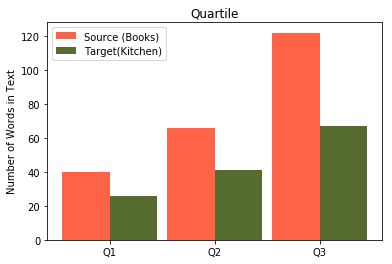

In [11]:
# WORDS DERIVED COLUMN
NUMBER_OF_WORDS_COLUMN = REVIEWS_COLUMN_NAME + 'NB_WORDS_COLUM'
# source data
source_review_dataframe[NUMBER_OF_WORDS_COLUMN] = source_review_dataframe[REVIEWS_COLUMN_NAME].str.split(
).apply(len)
source_data = source_review_dataframe[NUMBER_OF_WORDS_COLUMN].describe()

quartiles = ['Q1', 'Q2', 'Q3']
source = [source_data['25%'], source_data['50%'], source_data['75%']]


# target data
target_review_dataframe[NUMBER_OF_WORDS_COLUMN] = target_review_dataframe[REVIEWS_COLUMN_NAME].str.split(
).apply(len)
target_data = target_review_dataframe[NUMBER_OF_WORDS_COLUMN].describe()

quartiles = ['Q1', 'Q2', 'Q3']
target = [target_data['25%'], target_data['50%'], target_data['75%']]


fig, ax = plt.subplots()
indices = np.arange(3)
width = 0.45       # the width of the bars
rects1 = ax.bar(indices, source, width, color='tomato')
rects2 = ax.bar(indices + width, target, width, color='darkolivegreen')
# add some text for labels, title and axes ticks
ax.set_ylabel('Number of Words in Text')
ax.set_title('Quartile')
ax.set_xticks(indices + width / 2)
ax.set_xticklabels(('Q1', 'Q2', 'Q3'))
ax.legend((rects1[0], rects2[0]), ('Source (Books)', 'Target(Kitchen)'))
plt.show()






## 2. Word Cloud Distribution for Source and Target

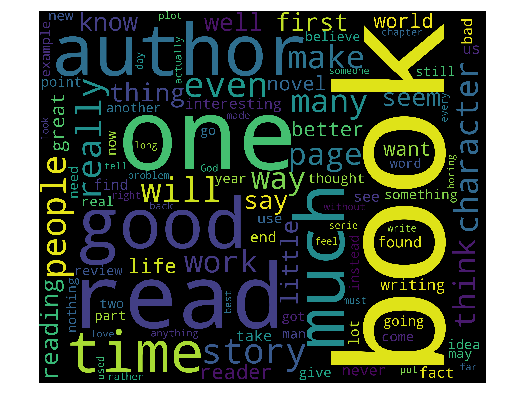

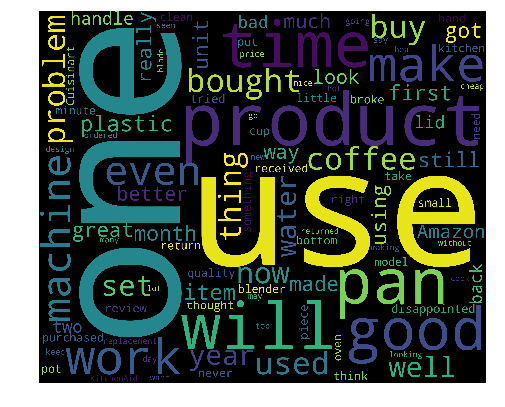

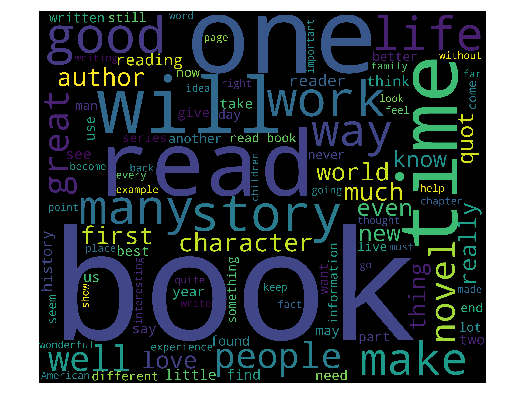

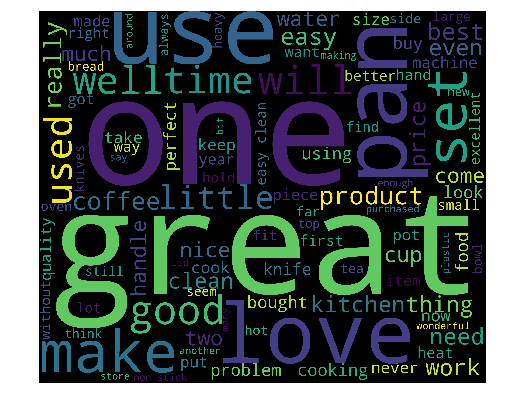

In [12]:
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
words_source_negative = ' '.join(source_negative_dataframe)
words_target_negative = ' '.join(target_negative_dataframe)
words_source_positive = ' '.join(source_positive_dataframe)
words_target_positive = ' '.join(target_positive_dataframe)
wordcloud_source_negative = WordCloud(max_words=100, stopwords=STOPWORDS,
                                      background_color='black',
                                      width=3000,
                                      height=2500
                                      ).generate(words_source_negative)
wordcloud_target_negative = WordCloud(max_words=100, stopwords=STOPWORDS,
                                      background_color='black',
                                      width=3000,
                                      height=2500
                                      ).generate(words_target_negative)
wordcloud_source_positive = WordCloud(max_words=100, stopwords=STOPWORDS,
                                      background_color='black',
                                      width=3000,
                                      height=2500
                                      ).generate(words_source_positive)
wordcloud_target_positive = WordCloud(max_words=100, stopwords=STOPWORDS,
                                      background_color='black',
                                      width=3000,
                                      height=2500
                                      ).generate(words_target_positive)
plt.figure(1, figsize=(8, 8))
plt.imshow(wordcloud_source_negative)
plt.axis('off')
plt.figure(2, figsize=(8, 8))
plt.imshow(wordcloud_target_negative)
plt.axis('off')
plt.figure(3, figsize=(8, 8))
plt.imshow(wordcloud_source_positive)
plt.axis('off')
plt.figure(4, figsize=(8, 8))
plt.imshow(wordcloud_target_positive)
plt.axis('off')
plt.show()



In [13]:
# tokenize all the reviews to get words from source and target
total_corpus = source_review_dataframe[REVIEWS_COLUMN_NAME].append(
    target_review_dataframe[REVIEWS_COLUMN_NAME])
tk.fit_on_texts(total_corpus.values.tolist())

# convert the text to sequence using the source and target  tokenizer
source_data_train_seq = tk.texts_to_sequences(
    source_data_train.values.tolist())
source_data_test_seq = tk.texts_to_sequences(source_data_test.values.tolist())

# convert the text to sequence using the source and target  tokenizer
target_data_train_seq = tk.texts_to_sequences(
    target_data_train.values.tolist())
target_data_test_seq = tk.texts_to_sequences(target_data_test.values.tolist())

# pad the sequence with maximum length of source and target
X_target_full_train = pad_sequences(target_data_train_seq, maxlen=MAX_LEN)
X_target_test = pad_sequences(target_data_test_seq, maxlen=MAX_LEN)

# pad the sequence with maximum length of source and target
X_source_full_train = pad_sequences(source_data_train_seq, maxlen=MAX_LEN)
X_source_test = pad_sequences(source_data_test_seq, maxlen=MAX_LEN)

# perform encoding of labels
le = LabelEncoder()
y_source_train_le = le.fit_transform(source_label_train)
y_source_test_le = le.transform(source_label_test)
y_source_full_train = to_categorical(y_source_train_le)
y_source_test = to_categorical(y_source_test_le)

y_target_train_le = le.fit_transform(target_label_train)
y_target_test_le = le.transform(target_label_test)
y_target_full_train = to_categorical(y_target_train_le)
y_target_test = to_categorical(y_target_test_le)

# labels from encoder mapping
TARGET_TEXT_LABELS = le.classes_
TEXT_LABELS = le.classes_

assert X_source_full_train.shape[0] == y_source_full_train.shape[0]
assert X_target_full_train.shape[0] == y_target_full_train.shape[0]


/Users/udaykamath/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/udaykamath/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Experiment 0: Kim's CNN with no pre-trained Embeddings, train on Source and Test on Target (worst case base to compare and contrast)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 100)     1500100     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 300, 128)     38528       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 300, 128)     51328       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

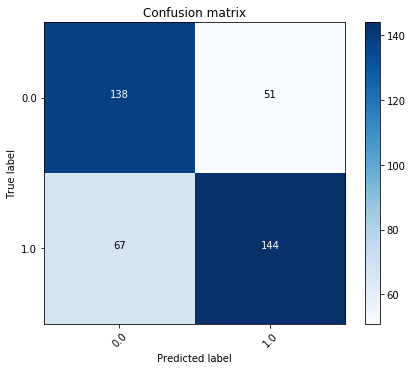

In [14]:
def kim_cnn():
    text_seq_input = Input(shape=(MAX_LEN,), dtype='int32')
    text_embedding = Embedding(NB_WORDS + 1,
                               GLOVE_DIM,
                               trainable=True,
                               input_length=MAX_LEN)(text_seq_input)

    filter_sizes = [3, 4, 5]
    convs = []
    for filter_size in filter_sizes:
        l_conv = Convolution1D(
            filters=128,
            kernel_size=filter_size,
            padding='same',
            activation='relu')(text_embedding)
        l_pool = MaxPooling1D(filter_size)(l_conv)
        convs.append(l_pool)

    merge = concatenate(convs, axis=1)
    convol = Convolution1D(128, 5, activation='relu')(merge)
    pool1 = GlobalMaxPooling1D()(convol)
    dense = Dense(128, activation='relu')(pool1)
    out = Dense(2, activation='softmax')(dense)
    model = Model(inputs=[text_seq_input], outputs=out)
    model.summary()
    return model


source_model = kim_cnn()
kim_cnn_model_history = train_model(
    source_model,
    X_source_full_train,
    y_source_full_train,
    number_of_epochs=15)
# test on the source first
results = source_model.evaluate(X_source_test, y_source_test)
print("Model Testing Accuracy Source: %s " % (results[1]))
results = source_model.evaluate(X_target_test, y_target_test)
print("Model Testing Accuracy Target: %s " % (results[1]))
y_test, y_pred = predict(source_model, X_target_test, y_target_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
plot_confusion_matrix(
    cnf_matrix,
    classes=TEXT_LABELS,
    title="Confusion matrix")
plt.show()


In [0]:
from keras.utils import plot_model
plot_model(source_model, to_file='model.png')

## Experiment 1: Kim's CNN with no pre-trained Embeddings, train on Target and Test on Target (best case base to compare and contrast)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 300, 100)     1500100     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 300, 128)     38528       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 300, 128)     51328       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_11 

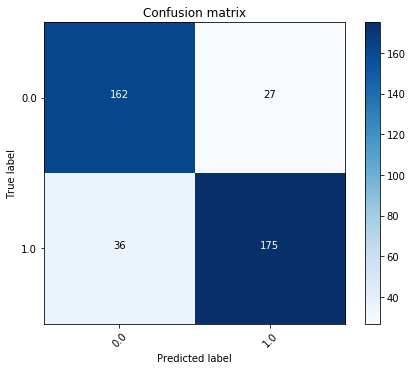

Model Training and Testing time : 115.93573093414307 secs
Model Testing Accuracy : 0.8425 
Average precision score: 0.81
Mean Test accuracy for Kim's CNN Model on Target Domain is 0.8425 and Std Dev 0.0


In [0]:
def kim_cnn():
    text_seq_input = Input(shape=(MAX_LEN,), dtype='int32')
    text_embedding = Embedding(NB_WORDS + 1,
                               GLOVE_DIM,
                               trainable=True,
                               input_length=MAX_LEN)(text_seq_input)

    filter_sizes = [3, 4, 5]
    convs = []
    for filter_size in filter_sizes:
        l_conv = Convolution1D(
            filters=128,
            kernel_size=filter_size,
            padding='same',
            activation='relu')(text_embedding)
        l_pool = MaxPooling1D(filter_size)(l_conv)
        convs.append(l_pool)

    merge = concatenate(convs, axis=1)
    convol = Convolution1D(128, 5, activation='relu')(merge)
    pool1 = GlobalMaxPooling1D()(convol)
    dense = Dense(128, activation='relu')(pool1)
    out = Dense(2, activation='softmax')(dense)
    model = Model(inputs=[text_seq_input], outputs=out)
    model.summary()
    return model


kim_cnn_model = kim_cnn()
kim_cnn_model_history = train_model(
    kim_cnn_model,
    X_target_full_train,
    y_target_full_train,
    number_of_epochs=15)
# run with regularizer afor 3 runs to see performance
multichannel_multifilter_cnn_model_mean_accuracy, multichannel_multifilter_cnn_model_std_dev = test_model_runs(
    kim_cnn_model, X_target_full_train, y_target_full_train, X_target_test, y_target_test, 15, 1)
print(
    "Mean Test accuracy for Kim's CNN Model on Target Domain is %s and Std Dev %s" %
    (multichannel_multifilter_cnn_model_mean_accuracy,
     multichannel_multifilter_cnn_model_std_dev))


## Experiment 2 : Kim's CNN with GloVe Embeddings (frozen) trained on target data and test on unseen target data

Shape of embedding matrix: (15001, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 300, 100)     1500100     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 300, 128)     38528       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 300, 128)     51328       embedding_2[0][0]                
_____________________________________________________________________

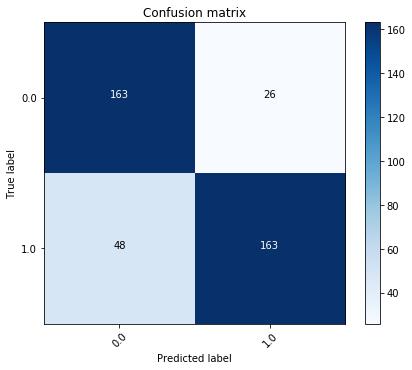

Model Training and Testing time : 94.99494290351868 secs
Model Testing Accuracy : 0.815 
Average precision score: 0.79
Mean Test accuracy for Kim's CNN Model on Target Domain is 0.815 and Std Dev 0.0


In [15]:
# read the embedding matrix
embeddings_index = read_embedding('./embeddings/glove.6B.100d.txt')
emb_matrix = create_embedding_matrix(tk, 100, embeddings_index)


def kim_cnn():
    text_seq_input = Input(shape=(MAX_LEN,), dtype='int32')
    text_embedding = Embedding(NB_WORDS + 1,
                               GLOVE_DIM,
                               weights=[emb_matrix],
                               trainable=False,
                               input_length=MAX_LEN)(text_seq_input)

    filter_sizes = [3, 4, 5]
    convs = []
    for filter_size in filter_sizes:
        l_conv = Convolution1D(
            filters=128,
            kernel_size=filter_size,
            padding='same',
            activation='relu')(text_embedding)
        l_pool = MaxPooling1D(filter_size)(l_conv)
        convs.append(l_pool)

    merge = concatenate(convs, axis=1)
    convol = Convolution1D(128, 5, activation='relu')(merge)
    pool1 = GlobalMaxPooling1D()(convol)
    dense = Dense(128, activation='relu')(pool1)
    out = Dense(2, activation='softmax')(dense)
    model = Model(inputs=[text_seq_input], outputs=out)
    model.summary()
    return model


kim_cnn_model = kim_cnn()
kim_cnn_model_history = train_model(
    kim_cnn_model,
    X_target_full_train,
    y_target_full_train,
    number_of_epochs=15)
# run with regularizer afor 3 runs to see performance
multichannel_multifilter_cnn_model_mean_accuracy, multichannel_multifilter_cnn_model_std_dev = test_model_runs(
    kim_cnn_model, X_target_full_train, y_target_full_train, X_target_test, y_target_test, 15, 1)
print(
    "Mean Test accuracy for Kim's CNN Model on Target Domain is %s and Std Dev %s" %
    (multichannel_multifilter_cnn_model_mean_accuracy,
     multichannel_multifilter_cnn_model_std_dev))


## Experiment 3: Kim's CNN with GloVe Embeddings (non-frozen) trained on target data and test on unseen target data

Shape of embedding matrix: (15001, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 300, 100)     1500100     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 300, 128)     38528       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 300, 128)     51328       embedding_3[0][0]                
_____________________________________________________________________

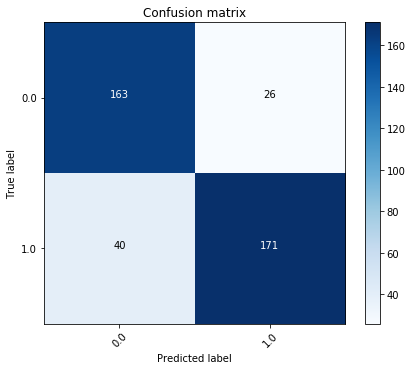

Model Training and Testing time : 113.83360004425049 secs
Model Testing Accuracy : 0.835 
Average precision score: 0.80
Mean Test accuracy for Kim's CNN Model on Target Domain is 0.835 and Std Dev 0.0


In [16]:

emb_matrix = create_embedding_matrix(tk, 100, embeddings_index)


def kim_cnn():
    text_seq_input = Input(shape=(MAX_LEN,), dtype='int32')
    text_embedding = Embedding(NB_WORDS + 1,
                               GLOVE_DIM,
                               weights=[emb_matrix],
                               trainable=True,
                               input_length=MAX_LEN)(text_seq_input)

    filter_sizes = [3, 4, 5]
    convs = []
    for filter_size in filter_sizes:
        l_conv = Convolution1D(
            filters=128,
            kernel_size=filter_size,
            padding='same',
            activation='relu')(text_embedding)
        l_pool = MaxPooling1D(filter_size)(l_conv)
        convs.append(l_pool)

    merge = concatenate(convs, axis=1)
    convol = Convolution1D(128, 5, activation='relu')(merge)
    pool1 = GlobalMaxPooling1D()(convol)
    dense = Dense(128, activation='relu')(pool1)
    out = Dense(2, activation='softmax')(dense)
    model = Model(inputs=[text_seq_input], outputs=out)
    model.summary()
    return model


kim_cnn_model = kim_cnn()
kim_cnn_model_history = train_model(
    kim_cnn_model,
    X_target_full_train,
    y_target_full_train,
    number_of_epochs=15)
# run with regularizer afor 3 runs to see performance
multichannel_multifilter_cnn_model_mean_accuracy, multichannel_multifilter_cnn_model_std_dev = test_model_runs(
    kim_cnn_model, X_target_full_train, y_target_full_train, X_target_test, y_target_test, 15, 1)
print(
    "Mean Test accuracy for Kim's CNN Model on Target Domain is %s and Std Dev %s" %
    (multichannel_multifilter_cnn_model_mean_accuracy,
     multichannel_multifilter_cnn_model_std_dev))


## Experiment 4: Train on source domain using GloVe embeddings, clone it, train on target domain and test on target with every layer trainable

In [17]:
# read the embedding matrix
emb_matrix = create_embedding_matrix(tk, 100, embeddings_index)

# create feature layers and classification layers
graph_in = Input(shape=(NB_WORDS + 1, 100))

convs = []
for filter_size in range(3, 5):
    x = Convolution1D(
        128,
        filter_size,
        padding='same',
        activation='relu')(graph_in)
    convs.append(x)

graph_out = concatenate(convs, axis=1)
graph_out = GlobalMaxPooling1D()(graph_out)
graph = Model(graph_in, graph_out)

feature_layers = [
    Embedding(
        NB_WORDS + 1,
        100,
        weights=[emb_matrix],
        trainable=True,
        input_length=MAX_LEN),
    graph]
classification_layers = [Dense(128, activation='relu'),
                         Dense(2, activation='softmax')]

source_model = Sequential(feature_layers + classification_layers)
source_model.summary()
model_history = train_model(
    source_model,
    X_source_full_train,
    y_source_full_train,
    number_of_epochs=15)


Shape of embedding matrix: (15001, 100)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 100)          1500100   
_________________________________________________________________
model_4 (Model)              (None, 128)               89856     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 258       
Total params: 1,606,726
Trainable params: 1,606,726
Non-trainable params: 0
_________________________________________________________________
Train on 1280 samples, validate on 320 samples
Epoch 1/15
1280/1280 [==============================] - 5s 4ms/step - loss: 0.8734 - acc: 0.5055 - val_loss: 0.8287 - val_acc: 0.5000
Epoch 2/15
1280/1280 [=====================

Train on 1280 samples, validate on 320 samples
Epoch 1/15
1280/1280 [==============================] - 4s 3ms/step - loss: 0.6916 - acc: 0.5086 - val_loss: 0.6898 - val_acc: 0.5063
Epoch 2/15
1280/1280 [==============================] - 4s 3ms/step - loss: 0.6712 - acc: 0.6789 - val_loss: 0.6839 - val_acc: 0.7094
Epoch 3/15
1280/1280 [==============================] - 4s 3ms/step - loss: 0.6499 - acc: 0.9883 - val_loss: 0.6768 - val_acc: 0.7563
Epoch 4/15
1280/1280 [==============================] - 4s 3ms/step - loss: 0.6222 - acc: 0.9969 - val_loss: 0.6664 - val_acc: 0.7031
Epoch 5/15
1280/1280 [==============================] - 4s 3ms/step - loss: 0.5878 - acc: 0.9891 - val_loss: 0.6507 - val_acc: 0.7812
Epoch 6/15
1280/1280 [==============================] - 4s 3ms/step - loss: 0.5436 - acc: 0.9977 - val_loss: 0.6282 - val_acc: 0.8438
Epoch 7/15
1280/1280 [==============================] - 4s 3ms/step - loss: 0.4910 - acc: 0.9984 - val_loss: 0.5982 - val_acc: 0.8469
Epoch 8/15
1280

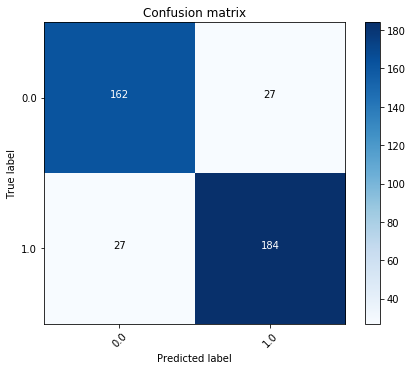

Model Training and Testing time : 79.84075784683228 secs
Model Testing Accuracy : 0.865 
Average precision score: 0.83
Mean Test accuracy for Source Model Trained on Source, trained on Target and tested on Target Domain is 0.865 and Std Dev 0.0


In [18]:
# clone the source model
target_model = models.clone_model(source_model)
# train the source model on target
domain_adaptation_history = train_model(
    target_model,
    X_target_full_train,
    y_target_full_train,
    number_of_epochs=15)
# run with regularizer afor 3 runs to see performance
multichannel_multifilter_cnn_model_mean_accuracy, multichannel_multifilter_cnn_model_std_dev = test_model_runs(
    target_model, X_target_full_train, y_target_full_train, X_target_test, y_target_test, 20, 1)
print("Mean Test accuracy for Source Model Trained on Source, trained on Target and tested on Target Domain is %s and Std Dev %s" %
      (multichannel_multifilter_cnn_model_mean_accuracy, multichannel_multifilter_cnn_model_std_dev))


## Experiment 5: Train on source domain using GloVe embeddings, clone it, train on target domain and test on target with feature layers frozen from source training. 

In [19]:
# read the embedding matrix
emb_matrix = create_embedding_matrix(tk, 100, embeddings_index)

# create feature layers and classification layers
graph_in = Input(shape=(NB_WORDS + 1, 100))

convs = []
for filter_size in range(3, 5):
    x = Convolution1D(
        128,
        filter_size,
        padding='same',
        activation='relu')(graph_in)
    convs.append(x)

graph_out = concatenate(convs, axis=1)
graph_out = GlobalMaxPooling1D()(graph_out)
graph = Model(graph_in, graph_out)

feature_layers = [
    Embedding(
        NB_WORDS + 1,
        100,
        weights=[emb_matrix],
        trainable=True,
        input_length=MAX_LEN),
    graph]
classification_layers = [Dense(128, activation='relu'),
                         Dense(2, activation='softmax')]

source_model = Sequential(feature_layers + classification_layers)
source_model.summary()
model_history = train_model(
    source_model,
    X_source_full_train,
    y_source_full_train,
    number_of_epochs=15)




Shape of embedding matrix: (15001, 100)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 100)          1500100   
_________________________________________________________________
model_5 (Model)              (None, 128)               89856     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 258       
Total params: 1,606,726
Trainable params: 1,606,726
Non-trainable params: 0
_________________________________________________________________
Train on 1280 samples, validate on 320 samples
Epoch 1/15
1280/1280 [==============================] - 5s 4ms/step - loss: 0.8722 - acc: 0.4641 - val_loss: 0.7901 - val_acc: 0.5000
Epoch 2/15
1280/1280 [=====================

Train on 1280 samples, validate on 320 samples
Epoch 1/15
1280/1280 [==============================] - 2s 1ms/step - loss: 0.6448 - acc: 0.6156 - val_loss: 0.5943 - val_acc: 0.6781
Epoch 2/15
1280/1280 [==============================] - 1s 968us/step - loss: 0.6304 - acc: 0.6328 - val_loss: 0.6131 - val_acc: 0.6656
Epoch 3/15
1280/1280 [==============================] - 1s 978us/step - loss: 0.5929 - acc: 0.6758 - val_loss: 0.6199 - val_acc: 0.6313
Epoch 4/15
1280/1280 [==============================] - 1s 1ms/step - loss: 0.6172 - acc: 0.6437 - val_loss: 0.5862 - val_acc: 0.6844
Epoch 5/15
1280/1280 [==============================] - 1s 993us/step - loss: 0.5914 - acc: 0.6844 - val_loss: 0.6103 - val_acc: 0.6781
Epoch 6/15
1280/1280 [==============================] - 1s 998us/step - loss: 0.5940 - acc: 0.6797 - val_loss: 0.5838 - val_acc: 0.6781
Epoch 7/15
1280/1280 [==============================] - 1s 999us/step - loss: 0.5892 - acc: 0.6930 - val_loss: 0.5948 - val_acc: 0.6719
Epoch

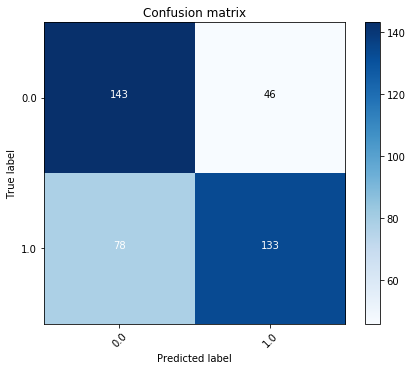

Model Training and Testing time : 30.499351978302002 secs
Model Testing Accuracy : 0.69 
Average precision score: 0.66
Mean Test accuracy for Source Model Trained on Source, trained on Target and tested on Target Domain is 0.69 and Std Dev 0.0


In [20]:
# target is source
target_model = source_model

# freeze the feature layers
for l in feature_layers:
    l.trainable = False

# train the source model on target
domain_adaptation_history = train_model(
    target_model,
    X_target_full_train,
    y_target_full_train,
    number_of_epochs=15)
# run with regularizer afor 3 runs to see performance
multichannel_multifilter_cnn_model_mean_accuracy, multichannel_multifilter_cnn_model_std_dev = test_model_runs(
    target_model, X_target_full_train, y_target_full_train, X_target_test, y_target_test, 20, 1)
print("Mean Test accuracy for Source Model Trained on Source, trained on Target and tested on Target Domain is %s and Std Dev %s" %
      (multichannel_multifilter_cnn_model_mean_accuracy, multichannel_multifilter_cnn_model_std_dev))


## Experiment 6: Stacked Autoencoders with DNN trained in unsupervised manner on source, feature layers extracted, connected with classification layers to train and test on target

In [21]:
model = Sequential()
model.add(Embedding(NB_WORDS + 1, 300))
model.compile('rmsprop', 'mse')

input_i = Input(shape=(300, 300))
encoded_h1 = Dense(128, activation='tanh')(input_i)
encoded_h2 = Dense(64, activation='tanh')(encoded_h1)
encoded_h3 = Dense(32, activation='tanh')(encoded_h2)
encoded_h4 = Dense(16, activation='tanh')(encoded_h3)
encoded_h5 = Dense(8, activation='tanh')(encoded_h4)
latent = Dense(2, activation='tanh')(encoded_h5)
decoder_h1 = Dense(8, activation='tanh')(latent)
decoder_h2 = Dense(16, activation='tanh')(decoder_h1)
decoder_h3 = Dense(32, activation='tanh')(decoder_h2)
decoder_h4 = Dense(64, activation='tanh')(decoder_h3)
decoder_h5 = Dense(128, activation='tanh')(decoder_h4)

output = Dense(300, activation='tanh')(decoder_h5)

autoencoder = Model(input_i, output)
autoencoder.summary()
autoencoder.compile('adadelta', 'mse')


X_source_full_train_embedded = model.predict(X_source_full_train)
autoencoder.fit(
    X_source_full_train_embedded,
    X_source_full_train_embedded,
    epochs=15,
    batch_size=256,
    validation_split=.1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 300, 300)          0         
_________________________________________________________________
dense_11 (Dense)             (None, 300, 128)          38528     
_________________________________________________________________
dense_12 (Dense)             (None, 300, 64)           8256      
_________________________________________________________________
dense_13 (Dense)             (None, 300, 32)           2080      
_________________________________________________________________
dense_14 (Dense)             (None, 300, 16)           528       
_________________________________________________________________
dense_15 (Dense)             (None, 300, 8)            136       
_________________________________________________________________
dense_16 (Dense)             (None, 300, 2)            18        
__________

In [22]:
model = Sequential()
model.add(Embedding(NB_WORDS + 1, 300))
model.compile('rmsprop', 'mse')

# train target on same embeddings
X_target_full_train_embedded = model.predict(X_target_full_train)

classification_model = Sequential()
classification_model.add(autoencoder.layers[0])
classification_model.add(autoencoder.layers[1])
classification_model.add(autoencoder.layers[2])
classification_model.add(autoencoder.layers[3])
classification_model.add(autoencoder.layers[4])
classification_model.add(autoencoder.layers[5])
classification_model.add(Flatten())
classification_model.add(Dense(2, activation='softmax'))
classification_model.compile(optimizer='rmsprop',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])
classification_model.summary()
classification_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Train the model, iterating on the data in batches of 32 samples
classification_model.fit(
    X_target_full_train_embedded,
    y_target_full_train,
    epochs=20,
    batch_size=32)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 300, 128)          38528     
_________________________________________________________________
dense_12 (Dense)             (None, 300, 64)           8256      
_________________________________________________________________
dense_13 (Dense)             (None, 300, 32)           2080      
_________________________________________________________________
dense_14 (Dense)             (None, 300, 16)           528       
_________________________________________________________________
dense_15 (Dense)             (None, 300, 8)            136       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 4802      
Total para

400/400 [==============================] - 0s 1ms/step
Confusion matrix, without normalization
[[135  54]
 [ 91 120]]


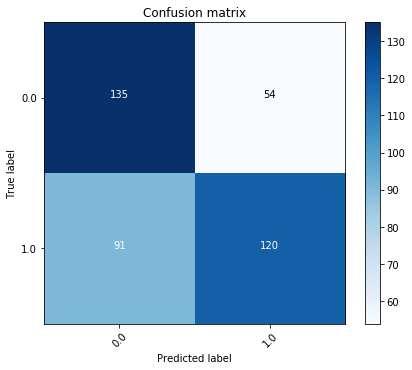

Model Testing Accuracy : 0.6375 
Average precision score: 0.71


In [23]:
# pass the test through embeddings
X_target_test_embedded = model.predict(X_target_test)

# test the models
results = classification_model.evaluate(X_target_test_embedded, y_target_test)
end = time.time()
y_softmax = classification_model.predict(X_target_test_embedded)
y_test_1d = []
y_pred_1d = []

for i in range(len(y_target_test)):
    probs = y_target_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(6, 5))
plot_confusion_matrix(
    cnf_matrix,
    classes=TEXT_LABELS,
    title="Confusion matrix")
plt.show()
print("Model Testing Accuracy : %s " % (results[1]))
average_precision = average_precision_score(
    y_target_test, y_softmax, average='weighted')
print('Average precision score: {0:0.2f}'.format(
      average_precision))


## Experiment 7: Stacked Autoencoders with CNN and Max Pooling, trained in unsupervised manner on source, feature layers extracted, connected with classification layers to train and test on target

In [24]:
NUM_WORDS = 3
pool_size = 2


model = Sequential()
model.add(Embedding(NB_WORDS + 1, 300))
model.compile('rmsprop', 'mse')

x = Input(shape=(300, 300))

h = x
h = Convolution1D(filters=300, kernel_size=NUM_WORDS,
                  activation="relu", padding='same', name='Conv1')(h)
h = MaxPooling1D(pool_size=pool_size, name='Maxpool1')(h)
h = Convolution1D(filters=150, kernel_size=NUM_WORDS,
                  activation="relu", padding='same', name='Conv2')(h)
h = MaxPooling1D(pool_size=pool_size, name="Maxpool2")(h)
h = Flatten()(h)
h = Dense(10, name='latent')(h)
y = h
y = Dense(11250, activation="relu")(y)
y = Reshape((75, 150))(y)
y = Convolution1D(filters=150, kernel_size=NUM_WORDS,
                  activation="relu", padding='same', name='conv-decode1')(y)
y = UpSampling1D(size=pool_size, name='upsampling1')(y)
y = Convolution1D(filters=300, kernel_size=NUM_WORDS,
                  activation="relu", padding='same', name='conv-decode2')(y)
y = UpSampling1D(size=pool_size, name='upsampling2')(y)

autoencoder = Model(x, y)
autoencoder.summary()
autoencoder.compile('adadelta', 'mse')


X_source_full_train_embedded = model.predict(X_source_full_train)
autoencoder.fit(
    X_source_full_train_embedded,
    X_source_full_train_embedded,
    epochs=15,
    batch_size=256,
    validation_split=.1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 300, 300)          0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 300, 300)          270300    
_________________________________________________________________
Maxpool1 (MaxPooling1D)      (None, 150, 300)          0         
_________________________________________________________________
Conv2 (Conv1D)               (None, 150, 150)          135150    
_________________________________________________________________
Maxpool2 (MaxPooling1D)      (None, 75, 150)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 11250)             0         
_________________________________________________________________
latent (Dense)               (None, 10)                112510    
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv1D)               (None, 300, 300)          270300    
_________________________________________________________________
Maxpool1 (MaxPooling1D)      (None, 150, 300)          0         
_________________________________________________________________
Conv2 (Conv1D)               (None, 150, 150)          135150    
_________________________________________________________________
Maxpool2 (MaxPooling1D)      (None, 75, 150)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 11250)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 22502     
Total params: 427,952
Trainable params: 427,952
Non-trainable params: 0
_________________________________________________________________
Epoc

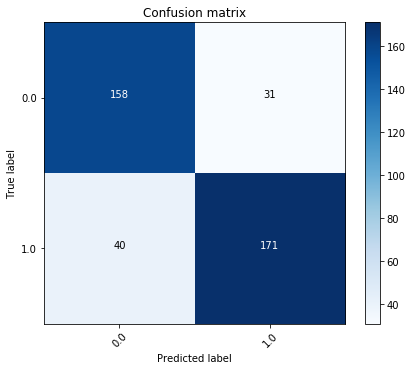

Model Testing Accuracy : 0.8225 
Average precision score: 0.90


In [25]:
model = Sequential()
model.add(Embedding(NB_WORDS + 1, 300))
model.compile('rmsprop', 'mse')

# train target on same embeddings
X_target_full_train_embedded = model.predict(X_target_full_train)

classification_model = Sequential()
classification_model.add(autoencoder.layers[0])
classification_model.add(autoencoder.layers[1])
classification_model.add(autoencoder.layers[2])
classification_model.add(autoencoder.layers[3])
classification_model.add(autoencoder.layers[4])
classification_model.add(autoencoder.layers[5])
classification_model.add(Dense(2, activation='softmax'))
classification_model.compile(optimizer='rmsprop',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])
classification_model.summary()
classification_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Train the model, iterating on the data in batches of 32 samples
classification_model.fit(
    X_target_full_train_embedded,
    y_target_full_train,
    epochs=20,
    batch_size=32)

# pass the test through embeddings
X_target_test_embedded = model.predict(X_target_test)

# test the models
results = classification_model.evaluate(X_target_test_embedded, y_target_test)
end = time.time()
y_softmax = classification_model.predict(X_target_test_embedded)
y_test_1d = []
y_pred_1d = []

for i in range(len(y_target_test)):
    probs = y_target_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(6, 5))
plot_confusion_matrix(
    cnf_matrix,
    classes=TEXT_LABELS,
    title="Confusion matrix")
plt.show()
print("Model Testing Accuracy : %s " % (results[1]))
average_precision = average_precision_score(
    y_target_test, y_softmax, average='weighted')
print('Average precision score: {0:0.2f}'.format(
      average_precision))


## Transformation to BOW Vectors of Source and Target for Experiments 

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
# load all the reviews and labels for the source and target
source_review_dataframe, source_label_dataframe, p, n = load_data(
    SOURCE_DOMAIN)
target_review_dataframe, target_label_dataframe, p, n = load_data(
    TARGET_DOMAIN)
# remove stop words and do basic preprocessing
source_review_dataframe[REVIEWS_COLUMN_NAME] = source_review_dataframe[REVIEWS_COLUMN_NAME].apply(
    remove_stopwords)
target_review_dataframe[REVIEWS_COLUMN_NAME] = target_review_dataframe[REVIEWS_COLUMN_NAME].apply(
    remove_stopwords)
total_corpus = source_review_dataframe[REVIEWS_COLUMN_NAME].append(
    target_review_dataframe[REVIEWS_COLUMN_NAME])
# n-gram on word level
bow_transformer = CountVectorizer(
    analyzer='word',
    max_features=MAX_FEATURES,
    ngram_range=(
        1,
        2))
# remove all stop words from the corpus
total_corpus.apply(remove_stopwords)
# fit the entire corpus first
bow_transformer.fit(total_corpus)
# size of the vocabulary
print(len(bow_transformer.vocabulary_))


10000


In [29]:
# transform source data to vectors
source_review_arrays = bow_transformer.transform(
    source_review_dataframe[REVIEWS_COLUMN_NAME]).toarray()
print(source_review_arrays.shape)
# transform target data to vectors
target_review_arrays = bow_transformer.transform(
    target_review_dataframe[REVIEWS_COLUMN_NAME]).toarray()
# entire source labels as encoded
# perform encoding of labels
le = LabelEncoder()
source_label_encoded = le.fit_transform(source_label_dataframe)
target_label_encoded = le.fit_transform(target_label_dataframe)


# source splits
source_data_train, source_data_test, source_label_train, source_label_test = train_test_split(
    source_review_arrays, source_label_encoded, test_size=0.2, random_state=37)
# target splits
target_data_train, target_data_test, target_label_train, target_label_test = train_test_split(
    target_review_arrays, target_label_encoded, test_size=0.2, random_state=37)


(2000, 10000)


/Users/udaykamath/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Experiment 8: Deep CORAL: Correlation Alignment for Deep Domain Adaptation

By Baochen Sun, Kate Saenko 
https://arxiv.org/abs/1607.01719

Deep neural networks are able to learn powerful representations from large quantities of labeled input data, however they cannot always generalize well across changes in input distributions. Domain adaptation algorithms have been proposed to compensate for the degradation in performance due to domain shift. In this paper, we address the case when the target domain is unlabeled, requiring unsupervised adaptation. CORAL is a "frustratingly easy" unsupervised domain adaptation method that aligns the second-order statistics of the source and target distributions with a linear transformation. Here, we extend CORAL to learn a nonlinear transformation that aligns correlations of layer activations in deep neural networks (Deep CORAL). Experiments on standard benchmark datasets show state-of-the-art performance.
<img src="attachment:DeepCORAL.png" width="500", height="400">

In [27]:
# moment alignment neural network algorithm
from correlation_alignment import CORALRegularizer
from central_moment_discrepancy import CMDRegularizer
from maximum_mean_discrepancy import MMDRegularizer
from mann_sentiment_analysis import MANN

MANN_HIDDEN_UNITS = 50
MANN_MAX_N_EPOCH = 1500
MANN_BATCH_SIZE = 300


def accuracy(y, y_true):
    """
    amount of right classified reviews
    """
    return 1 - np.sum(np.abs(np.round(y).ravel() -
                             y_true.ravel())) / y.shape[0]


In [34]:

# Neural Network fit
nn = MANN(n_features=MAX_FEATURES, n_hiddens=MANN_HIDDEN_UNITS,
          n_epochs=MANN_MAX_N_EPOCH, bsize=MANN_BATCH_SIZE, save_weights='nn')
nn.fit(source_data_train, source_label_train, target_data_train, verbose=1)

# deep coral
coral = CORALRegularizer(1.)
deep_coral = MANN(n_features=MAX_FEATURES, n_hiddens=MANN_HIDDEN_UNITS,
                  n_epochs=MANN_MAX_N_EPOCH, bsize=MANN_BATCH_SIZE,
                  activity_regularizer=coral)
deep_coral.fit(
    source_data_train,
    source_label_train,
    target_data_train,
    verbose=1,
    init_weights='nn')
target_test_predictions = deep_coral.predict(target_data_test)
print('Accuracy of deep coral: ' +
      str(accuracy(target_label_test, target_test_predictions)))


/Users/udaykamath/SpringerNLP_041518/Chapter-Notebooks/Chapter-11/mann_sentiment_analysis.py:81: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  output=[pred_s,pred_t])
/Users/udaykamath/SpringerNLP_041518/Chapter-Notebooks/Chapter-11/mann_sentiment_analysis.py:103: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  output=[encoded_s,encoded_t])
/Users/udaykamath/SpringerNLP_041518/Chapter-Notebooks/Chapter-11/mann_sentiment_analysis.py:133: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_split=0.3)


Train on 1120 samples, validate on 480 samples
Epoch 1/1500
1120/1120 [==============================] - 1s 1ms/step - loss: 0.8340 - pred_loss: 0.3688 - pred_acc: 0.5438 - pred_acc_1: 0.9179 - val_loss: 0.6354 - val_pred_loss: 0.3658 - val_pred_acc: 0.6083 - val_pred_acc_1: 0.9708
Epoch 2/1500
1120/1120 [==============================] - 0s 203us/step - loss: 0.4153 - pred_loss: 0.4230 - pred_acc: 0.8277 - pred_acc_1: 0.9268 - val_loss: 0.5644 - val_pred_loss: 0.4819 - val_pred_acc: 0.6937 - val_pred_acc_1: 0.8792
Epoch 3/1500
1120/1120 [==============================] - 0s 197us/step - loss: 0.3107 - pred_loss: 0.4893 - pred_acc: 0.9304 - pred_acc_1: 0.8634 - val_loss: 0.5320 - val_pred_loss: 0.5262 - val_pred_acc: 0.7292 - val_pred_acc_1: 0.8125
Epoch 4/1500
1120/1120 [==============================] - 0s 201us/step - loss: 0.2559 - pred_loss: 0.5257 - pred_acc: 0.9643 - pred_acc_1: 0.8205 - val_loss: 0.5109 - val_pred_loss: 0.5532 - val_pred_acc: 0.7646 - val_pred_acc_1: 0.7750
Epo

Epoch 2/1500
1120/1120 [==============================] - 0s 207us/step - loss: 0.2259 - pred_loss: 0.6341 - pred_acc: 0.9714 - pred_acc_1: 0.6545 - val_loss: 0.4937 - val_pred_loss: 0.5156 - val_pred_acc: 0.7583 - val_pred_acc_1: 0.7729
Epoch 3/1500
1120/1120 [==============================] - 0s 207us/step - loss: 0.1699 - pred_loss: 0.5793 - pred_acc: 0.9857 - pred_acc_1: 0.7089 - val_loss: 0.4736 - val_pred_loss: 0.6088 - val_pred_acc: 0.7813 - val_pred_acc_1: 0.6687
Epoch 4/1500
1120/1120 [==============================] - 0s 218us/step - loss: 0.1390 - pred_loss: 0.6206 - pred_acc: 0.9946 - pred_acc_1: 0.6652 - val_loss: 0.4657 - val_pred_loss: 0.6384 - val_pred_acc: 0.7833 - val_pred_acc_1: 0.6479
Epoch 5/1500
1120/1120 [==============================] - 0s 208us/step - loss: 0.1181 - pred_loss: 0.6420 - pred_acc: 0.9964 - pred_acc_1: 0.6500 - val_loss: 0.4605 - val_pred_loss: 0.6609 - val_pred_acc: 0.7896 - val_pred_acc_1: 0.6437
Epoch 6/1500
1120/1120 [========================

## Experiment 9:  Central moment discrepancy (CMD) for domain-invariant representation learning

<img src="attachment:CMD-Paper.png">

W.Zellinger, T. Grubinger, E. Lughofer, T. Natschlaeger, and Susanne Saminger-Platz, "Central moment discrepancy (cmd) for domain-invariant representation learning," International Conference on Learning Representations (ICLR), 2017 (Abstract)

The learning of domain-invariant representations in the context of domain adaptation
with neural networks is considered. We propose a new regularization
method that minimizes the domain-specific latent feature representations directly
in the hidden activation space. Although some standard distribution matching
approaches exist that can be interpreted as the matching of weighted sums of
moments, e.g. Maximum Mean Discrepancy, an explicit order-wise matching of
higher order moments has not been considered before. We propose to match the
higher order central moments of probability distributions by means of order-wise
moment differences. Our model does not require computationally expensive distance
and kernel matrix computations. We utilize the equivalent representation of
probability distributions by moment sequences to define a new distance function,
called Central Moment Discrepancy (CMD). We prove that CMD is a metric on
the set of probability distributions on a compact interval. We further prove that
convergence of probability distributions on compact intervals w. r. t. the new metric
implies convergence in distribution of the respective random variables. We test
our approach on two different benchmark data sets for object recognition (Office)
and sentiment analysis of product reviews (Amazon reviews). CMD achieves a
new state-of-the-art performance on most domain adaptation tasks of Office and
outperforms networks trained with Maximum Mean Discrepancy, Variational Fair
Autoencoders and Domain Adversarial Neural Networks on Amazon reviews. In
addition, a post-hoc parameter sensitivity analysis shows that the new approach
is stable w. r. t. parameter changes in a certain interval. 



<img src="attachment:CMD-Paper.png">

In [35]:
cmd = CMDRegularizer(1.)
deep_coral = MANN(n_features=MAX_FEATURES, n_hiddens=MANN_HIDDEN_UNITS,
                  n_epochs=MANN_MAX_N_EPOCH, bsize=MANN_BATCH_SIZE,
                  activity_regularizer=cmd)
deep_coral.fit(
    source_data_train,
    source_label_train,
    target_data_train,
    verbose=1,
    init_weights='nn')
target_test_predictions = deep_coral.predict(target_data_test)
print('Accuracy of deep CMD: ' +
      str(accuracy(target_label_test, target_test_predictions)))

/Users/udaykamath/SpringerNLP_041518/Chapter-Notebooks/Chapter-11/mann_sentiment_analysis.py:81: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  output=[pred_s,pred_t])
/Users/udaykamath/SpringerNLP_041518/Chapter-Notebooks/Chapter-11/mann_sentiment_analysis.py:103: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  output=[encoded_s,encoded_t])
/Users/udaykamath/SpringerNLP_041518/Chapter-Notebooks/Chapter-11/mann_sentiment_analysis.py:133: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_split=0.3)


Train on 1120 samples, validate on 480 samples
Epoch 1/1500
1120/1120 [==============================] - 1s 1ms/step - loss: 0.4016 - pred_loss: 0.4739 - pred_acc: 0.8482 - pred_acc_1: 0.8545 - val_loss: 0.5773 - val_pred_loss: 0.7969 - val_pred_acc: 0.7458 - val_pred_acc_1: 0.4771
Epoch 2/1500
1120/1120 [==============================] - 0s 218us/step - loss: 0.2257 - pred_loss: 0.6349 - pred_acc: 0.9714 - pred_acc_1: 0.6527 - val_loss: 0.4937 - val_pred_loss: 0.5156 - val_pred_acc: 0.7583 - val_pred_acc_1: 0.7729
Epoch 3/1500
1120/1120 [==============================] - 0s 206us/step - loss: 0.1697 - pred_loss: 0.5796 - pred_acc: 0.9857 - pred_acc_1: 0.7098 - val_loss: 0.4735 - val_pred_loss: 0.6091 - val_pred_acc: 0.7813 - val_pred_acc_1: 0.6687
Epoch 4/1500
1120/1120 [==============================] - 0s 205us/step - loss: 0.1387 - pred_loss: 0.6211 - pred_acc: 0.9946 - pred_acc_1: 0.6643 - val_loss: 0.4656 - val_pred_loss: 0.6389 - val_pred_acc: 0.7833 - val_pred_acc_1: 0.6458
Epo

## Experiment 10: Deep Maximum Mean Discrepancy (MMD)

https://www.ijcai.org/Proceedings/09/Papers/200.pdf

Domain Adaptation via Transfer Component Analysis
Sinno Jialin Pan, Ivor W. Tsang, James T. Kwok1 and Qiang Yang

(Abstract)
Domain adaptation solves a learning problem in a target domain by utilizing the training data in a different but related source domain. Intuitively, discovering a good feature representation across domains is crucial. In this paper, we propose to find such a representation through a new learning method, transfer component analysis (TCA), for domain adaptation. TCA tries to learn some transfer components across domains in a Reproducing Kernel Hilbert Space (RKHS) using Maximum Mean Discrepancy (MMD). In the subspace spanned by these transfer components, data distributions in different domains are close to each other. As a result, with the new representations in this subspace, we can apply standard machine learning methods to train classifiers or regression models in the source domain for use in the target domain. The main contribution of our work is that we propose a novel feature representation in which to perform domain adaptation via a new parametric kernel using feature extraction methods, which can dramatically minimize the distance between domain distributions by projecting data onto the learned transfer components. Furthermore, our approach can handle large datsets and naturally lead to out-of-sample generalization. The effectiveness and efficiency of our approach in are verified by experiments on two real-world applications: cross-domain indoor WiFi localization and cross-domain text classification.

In [36]:
from scipy.spatial.distance import pdist

# Neural Network fit
nn = MANN(n_features=MAX_FEATURES, n_hiddens=MANN_HIDDEN_UNITS,
          n_epochs=MANN_MAX_N_EPOCH, bsize=MANN_BATCH_SIZE, save_weights='nn')
nn.fit(source_data_train, source_label_train, target_data_train, verbose=1)

# use the activations
a_s, a_t = nn.get_activations(source_data_train, target_data_train)
a = np.concatenate((a_s, a_t), axis=0)
b = 1.0 / np.median(pdist(a))

# train with mmd
mmd = MMDRegularizer(1., beta=b)
deep_coral = MANN(n_features=MAX_FEATURES, n_hiddens=MANN_HIDDEN_UNITS,
                  n_epochs=MANN_MAX_N_EPOCH, bsize=MANN_BATCH_SIZE,
                  activity_regularizer=mmd)
deep_coral.fit(
    source_data_train,
    source_label_train,
    target_data_train,
    verbose=1,
    init_weights='nn')
target_test_predictions = deep_coral.predict(target_data_test)
print('Accuracy of deep MMD: ' +
      str(accuracy(target_label_test, target_test_predictions)))


/Users/udaykamath/SpringerNLP_041518/Chapter-Notebooks/Chapter-11/mann_sentiment_analysis.py:81: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  output=[pred_s,pred_t])
/Users/udaykamath/SpringerNLP_041518/Chapter-Notebooks/Chapter-11/mann_sentiment_analysis.py:103: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  output=[encoded_s,encoded_t])
/Users/udaykamath/SpringerNLP_041518/Chapter-Notebooks/Chapter-11/mann_sentiment_analysis.py:133: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_split=0.3)


Train on 1120 samples, validate on 480 samples
Epoch 1/1500
1120/1120 [==============================] - 1s 1ms/step - loss: 0.8340 - pred_loss: 0.3688 - pred_acc: 0.5438 - pred_acc_1: 0.9179 - val_loss: 0.6354 - val_pred_loss: 0.3658 - val_pred_acc: 0.6083 - val_pred_acc_1: 0.9708
Epoch 2/1500
1120/1120 [==============================] - 0s 205us/step - loss: 0.4153 - pred_loss: 0.4230 - pred_acc: 0.8277 - pred_acc_1: 0.9268 - val_loss: 0.5644 - val_pred_loss: 0.4819 - val_pred_acc: 0.6937 - val_pred_acc_1: 0.8792
Epoch 3/1500
1120/1120 [==============================] - 0s 207us/step - loss: 0.3107 - pred_loss: 0.4893 - pred_acc: 0.9304 - pred_acc_1: 0.8634 - val_loss: 0.5320 - val_pred_loss: 0.5262 - val_pred_acc: 0.7292 - val_pred_acc_1: 0.8125
Epoch 4/1500
1120/1120 [==============================] - 0s 209us/step - loss: 0.2559 - pred_loss: 0.5257 - pred_acc: 0.9643 - pred_acc_1: 0.8205 - val_loss: 0.5109 - val_pred_loss: 0.5532 - val_pred_acc: 0.7646 - val_pred_acc_1: 0.7750
Epo

Epoch 2/1500
1120/1120 [==============================] - 0s 217us/step - loss: 0.2259 - pred_loss: 0.6341 - pred_acc: 0.9714 - pred_acc_1: 0.6545 - val_loss: 0.4937 - val_pred_loss: 0.5156 - val_pred_acc: 0.7583 - val_pred_acc_1: 0.7729
Epoch 3/1500
1120/1120 [==============================] - 0s 216us/step - loss: 0.1699 - pred_loss: 0.5793 - pred_acc: 0.9857 - pred_acc_1: 0.7089 - val_loss: 0.4736 - val_pred_loss: 0.6088 - val_pred_acc: 0.7813 - val_pred_acc_1: 0.6687
Epoch 4/1500
1120/1120 [==============================] - 0s 212us/step - loss: 0.1390 - pred_loss: 0.6206 - pred_acc: 0.9946 - pred_acc_1: 0.6652 - val_loss: 0.4657 - val_pred_loss: 0.6384 - val_pred_acc: 0.7833 - val_pred_acc_1: 0.6479
Epoch 5/1500
1120/1120 [==============================] - 0s 218us/step - loss: 0.1181 - pred_loss: 0.6420 - pred_acc: 0.9964 - pred_acc_1: 0.6500 - val_loss: 0.4605 - val_pred_loss: 0.6609 - val_pred_acc: 0.7896 - val_pred_acc_1: 0.6437
Epoch 6/1500
1120/1120 [========================

## Experiment 11: Marginalized Stacked Denoising Autoencoders (mSDA) for Domain Adaptation

Minmin Chen, Zhixiang (Eddie) Xu, Kilian Q. Weinberger

(Abstract)
Stacked denoising autoencoders (SDAs) have been successfully used to learn new representations for domain adaptation. Recently, they have attained record accuracy on standard benchmark tasks of sentiment analysis across different text domains. SDAs learn robust data representations by reconstruction, recovering original features from data that are artificially corrupted with noise. In this paper, we propose marginalized SDA (mSDA) that addresses two crucial limitations of SDAs: high computational cost and lack of scalability to high-dimensional features. In contrast to SDAs, our approach of mSDA marginalizes noise and thus does not require stochastic gradient descent or other optimization algorithms to learn parameters — in fact, they are computed in closed-form. Consequently, mSDA, which can be implemented in only 20 lines of MATLABTM, significantly speeds up SDAs by two orders of magnitude. Furthermore, the representations learnt by mSDA are as effective as the traditional SDAs, attaining almost identical accuracies in benchmark tasks.
<img src="attachment:" width="600", height="400">

In [37]:
import numpy as np


def compute_msda_representation(x_source, x_target, x_test):
    nb_souce = np.shape(x_source)[0]
    x_train = np.vstack((x_source, x_target))
    new_x_train, W = msda_fit(x_train.T)
    mew_x_source = new_x_train[:,:nb_souce].T
    new_x_target = new_x_train[:,nb_souce:].T
    new_x_test = msda_forward(x_test.T, W).T
    return mew_x_source, new_x_target, new_x_test


def mda_fit(X, noise=0.5, eta=1e-5):
    """
    inputs: 
        X : d x n input (Transpose of the usual data-matrix)
        noise: corruption level
        eta: regularization 
    
    outputs:
        hx: d x n hidden representation
        W: d x (d+1) mapping
    """
    d, n = np.shape(X)
    
    # adding bias
    Xb = np.vstack((X, np.ones(n)))
    
    # scatter matrix S
    S = np.dot(Xb, Xb.T)
    
    # corruption vector
    q = np.ones((d+1, 1)) * (1.-noise)
    q[-1] = 1
    
    # Q: (d+1)x(d+1)
    Q = S*np.dot(q,q.T)
    Q[np.diag_indices_from(Q)] = q.T[0] * np.diag(S)

    #P: dx(d+1)
    P = S[0:-1,:] * q.T 
    
    # final W = P*Q^-1, dx(d+1)
    reg = eta * np.eye(d+1)
    reg[-1,-1] = 0
    W = np.linalg.solve(Q.T + reg, P.T).T

    hx = np.tanh(np.dot(W, Xb))
    return hx, W

   
def msda_fit(X, noise=0.5, nb_layers=5, verbose=False):
    """
    inputs:
        X : d x n input Transpose of the usual data-matrix)
        noise: corruption level
        nb_layers: number of layers to stack

    outputs:
        allhx: (1+nb_layers)*d x n stacked hidden representations
        W_list: list of mapping (of size nb_layers)
    """
    eta = 1e-05
    allhx = X.copy()
    prevhx = X
    W_list = []
    
    for i in range(nb_layers):
        if verbose: print('layer =', i)
        newhx, W = mda_fit(prevhx, noise, eta)
        W_list.append(W)
        allhx = np.vstack((allhx, newhx))
        prevhx = newhx

    return allhx, W_list


def msda_forward(X, W_list):
    """
    inputs: 
        X : d x n input (Transpose of the usual data-matrix)
        noise: corruption level
        W_list: list of mapping (of size nb_layers) learned by mSDA.
    
    outputs:
        allhx: (1+nb_layers)*d x n stacked hidden representations of X.
        
    """
    _, n = np.shape(X)   
    hx = X    
    
    allhx = X.copy()
    for W in W_list:
        hxb = np.vstack(( hx, np.ones(n)) )
        hx = np.tanh( np.dot(W, hxb) )        
        allhx = np.vstack( (allhx, hx) )
        
    return allhx    
    

In [38]:
xs_msda, xt_msda, xtest_msda = compute_msda_representation(source_data_train, target_data_train, target_data_test)


In [39]:
# train representation
X_train_reps = np.hstack([source_data_train, xs_msda])
# test representation
X_test_reps = np.hstack([target_data_test, xtest_msda])


In [40]:
from sklearn import svm
classifier = svm.SVC().fit(X_train_reps, source_label_train)
prediction_test = classifier.predict(X_test_reps)
print('Test Error       = %f' % np.mean(prediction_test != target_label_test))

Test Error       = 0.520000


## Experiment 12: Domain-Adversarial Training of Neural Networks


https://arxiv.org/abs/1505.07818
Yaroslav Ganin, Evgeniya Ustinova, Hana Ajakan, Pascal Germain, Hugo Larochelle, François Laviolette, Mario Marchand, Victor Lempitsky.

We introduce a new representation learning approach for domain adaptation, in which data at training and test time come from similar but different distributions. Our approach is directly inspired by the theory on domain adaptation suggesting that, for effective domain transfer to be achieved, predictions must be made based on features that cannot discriminate between the training (source) and test (target) domains. The approach implements this idea in the context of neural network architectures that are trained on labeled data from the source domain and unlabeled data from the target domain (no labeled target-domain data is necessary). As the training progresses, the approach promotes the emergence of features that are (i) discriminative for the main learning task on the source domain and (ii) indiscriminate with respect to the shift between the domains. We show that this adaptation behaviour can be achieved in almost any feed-forward model by augmenting it with few standard layers and a new gradient reversal layer. The resulting augmented architecture can be trained using standard backpropagation and stochastic gradient descent, and can thus be implemented with little effort using any of the deep learning packages. We demonstrate the success of our approach for two distinct classification problems (document sentiment analysis and image classification), where state-of-the-art domain adaptation performance on standard benchmarks is achieved. We also validate the approach for descriptor learning task in the context of person re-identification application.
<img src="attachment:DANN.png" width="600", height="400">


In [41]:
import os
import time
import numpy as np
from math import sqrt

# Code adapted from https://github.com/GRAAL-Research/domain_adversarial_neural_network

class DANN(object):
    
    def __init__(self, learning_rate=0.05, hidden_layer_size=25, lambda_adapt=1., maxiter=200,  
                 epsilon_init=None, adversarial_representation=True, seed=12342, verbose=False):
        """
        Domain Adversarial Neural Network for classification
        
        option "learning_rate" is the learning rate of the neural network.
        option "hidden_layer_size" is the hidden layer size.
        option "lambda_adapt" weights the domain adaptation regularization term.
                if 0 or None or False, then no domain adaptation regularization is performed
        option "maxiter" number of training iterations.
        option "epsilon_init" is a term used for initialization.
                if None the weight matrices are weighted by 6/(sqrt(r+c))
                (where r and c are the dimensions of the weight matrix)
        option "adversarial_representation": if False, the adversarial classifier is trained
                but has no impact on the hidden layer representation. The label predictor is
                then the same as a standard neural-network one (see experiments_moon.py figures). 
        option "seed" is the seed of the random number generator.
        """
        
        self.hidden_layer_size = hidden_layer_size
        self.maxiter = maxiter
        self.lambda_adapt = lambda_adapt if lambda_adapt not in (None, False) else 0.
        self.epsilon_init = epsilon_init
        self.learning_rate = learning_rate
        self.adversarial_representation = adversarial_representation
        self.seed = seed
        self.verbose = verbose
            
    def sigmoid(self, z):
        """
        Sigmoid function.
        
        """
        return 1. / (1. + np.exp(-z))
    
    def softmax(self, z):
        """
        Softmax function.
        
        """
        v = np.exp(z)
        return v / np.sum(v,axis=0)
       
    def random_init(self, l_in, l_out):
        """
        This method is used to initialize the weight matrices of the DA neural network 
        
        """
        if self.epsilon_init is not None:
            epsilon = self.epsilon_init 
        else:
            epsilon = sqrt(6.0 / (l_in + l_out))
            
        return epsilon * (2 * np.random.rand(l_out, l_in) - 1.0)
       
    def fit(self, X, Y, X_adapt, X_valid=None, Y_valid=None, do_random_init=True):
        """         
        Trains the domain adversarial neural network until it reaches a total number of
        iterations of "self.maxiter" since it was initialize.
        inputs:
              X : Source data matrix
              Y : Source labels
              X_adapt : Target data matrix
              (X_valid, Y_valid) : validation set used for early stopping.
              do_random_init : A boolean indicating whether to use random initialization or not.
        """
        
        nb_examples, nb_features = np.shape(X)
        nb_labels = len(set(Y))
        nb_examples_adapt, _ = np.shape(X_adapt)

        if self.verbose:
            print('[DANN parameters]', self.__dict__)
        
        np.random.seed(self.seed)
        
        if do_random_init:
            W = self.random_init(nb_features, self.hidden_layer_size)
            V = self.random_init(self.hidden_layer_size, nb_labels)
            b = np.zeros(self.hidden_layer_size)
            c = np.zeros(nb_labels)
            U = np.zeros(self.hidden_layer_size)
            d = 0.
        else:
            W, V, b, c, U, d = self.W, self.V, self.b, self.c, self.U, self.d 
            
        best_valid_risk = 2.0
        continue_until = 30

        for t in range(self.maxiter):
            for i in range(nb_examples):
                x_t, y_t = X[i,:], Y[i]
                
                hidden_layer = self.sigmoid(np.dot(W, x_t) + b)
                output_layer = self.softmax(np.dot(V, hidden_layer) + c)
                
                y_hot = np.zeros(nb_labels)
                y_hot[y_t] = 1.0
                 
                delta_c = output_layer - y_hot  
                delta_V = np.dot(delta_c.reshape(-1,1), hidden_layer.reshape(1,-1)) 
                delta_b = np.dot(V.T, delta_c) * hidden_layer * (1.-hidden_layer) 
                delta_W = np.dot(delta_b.reshape(-1,1), x_t.reshape(1,-1)) 
                
                if self.lambda_adapt == 0.:
                    delta_U, delta_d = 0., 0.
                else:
                    # add domain adaptation regularizer from current domain
                    gho_x_t = self.sigmoid(np.dot(U.T, hidden_layer) + d)
                    
                    delta_d = self.lambda_adapt * (1. - gho_x_t) 
                    delta_U = delta_d * hidden_layer 

                    if self.adversarial_representation:
                        tmp = delta_d * U * hidden_layer * (1. - hidden_layer)
                        delta_b += tmp
                        delta_W += tmp.reshape(-1,1) * x_t.reshape(1,-1)
                    
                    # add domain adaptation regularizer from other domain
                    i_2 = np.random.randint(nb_examples_adapt)
                    x_t_2 = X_adapt[i_2, :]
                    hidden_layer_2 = self.sigmoid( np.dot(W, x_t_2) + b)
                    gho_x_t_2 = self.sigmoid(np.dot(U.T, hidden_layer_2) + d) 
                    
                    delta_d -= self.lambda_adapt * gho_x_t_2 
                    delta_U -= self.lambda_adapt * gho_x_t_2 * hidden_layer_2

                    if self.adversarial_representation:
                        tmp = -self.lambda_adapt * gho_x_t_2 * U * hidden_layer_2 * (1. - hidden_layer_2)
                        delta_b += tmp
                        delta_W += tmp.reshape(-1,1) * x_t_2.reshape(1,-1)
          
                W -= delta_W * self.learning_rate
                b -= delta_b * self.learning_rate
     
                V -= delta_V * self.learning_rate
                c -= delta_c * self.learning_rate
                
                U += delta_U * self.learning_rate 
                d += delta_d * self.learning_rate 
            # END for i in range(nb_examples)

            self.W, self.V, self.b, self.c, self.U, self.d = W, V, b, c, U, d
            
            # early stopping
            if X_valid is not None:
                valid_pred = self.predict(X_valid)
                valid_risk = np.mean( valid_pred != Y_valid )
                if valid_risk <= best_valid_risk:
                    if self.verbose: 
                        print('[DANN best valid risk so far] %f (iter %d)' % (valid_risk, t))
                    best_valid_risk = valid_risk
                    best_weights = (W.copy(), V.copy(), b.copy(), c.copy())
                    best_t = t
                    continue_until = max(continue_until, int(1.5*t))
                elif t > continue_until: 
                    if self.verbose: 
                        print('[DANN early stop] iter %d' % t)
                    break
        # END for t in range(self.maxiter)
        
        if X_valid is not None:
            self.W, self.V, self.b, self.c = best_weights
            self.nb_iter = best_t
            self.valid_risk = best_valid_risk
        else:
            self.nb_iter = self.maxiter
            self.valid_risk = 2.
            
    def forward(self, X):
        """
         Compute and return the network outputs for X, i.e., a 2D array of size len(X) by len(set(Y)).
         the ith row of the array contains output probabilities for each class for the ith example.
         
        """
        hidden_layer = self.sigmoid(np.dot(self.W, X.T) + self.b[:,np.newaxis])
        output_layer = self.softmax(np.dot(self.V, hidden_layer) + self.c[:,np.newaxis])
        return output_layer

    def hidden_representation(self, X):
        """
         Compute and return the network hidden layer values for X.
        """
        hidden_layer = self.sigmoid(np.dot(self.W, X.T) + self.b[:,np.newaxis])
        return hidden_layer.T

    def predict(self, X):
        """
         Compute and return the label predictions for X, i.e., a 1D array of size len(X).
         the ith row of the array contains the predicted class for the ith example .
        """
        output_layer = self.forward(X)
        return np.argmax(output_layer, 0)

    def predict_domain(self, X):
        """
         Compute and return the domain predictions for X, i.e., a 1D array of size len(X).
         the ith row of the array contains the predicted domain (0 or 1) for the ith example.
        """
        hidden_layer = self.sigmoid(np.dot(self.W, X.T) + self.b[:, np.newaxis])
        output_layer = self.sigmoid(np.dot(self.U, hidden_layer) + self.d)
        return np.array(output_layer < .5, dtype=int)


In [42]:
import numpy as np
from DANN import DANN
from sklearn.datasets import load_svmlight_files
from sklearn import svm

adversarial = True
msda = False
hidden_layer_size = 50
lambda_adapt = 0.1 if adversarial else 0.
learning_rate = 0.001 if not msda else 0.0001
maxiter = 200

dann = DANN(
    lambda_adapt=lambda_adapt,
    hidden_layer_size=hidden_layer_size,
    learning_rate=learning_rate,
    maxiter=maxiter,
    epsilon_init=None,
    seed=12342,
    adversarial_representation=adversarial,
    verbose=True)

In [43]:
dann.fit(
    source_data_train,
    source_label_train,
    target_data_train,
    source_data_test,
    source_label_test)
prediction_test = dann.predict(target_data_test)
print('Test Error       = %f' % np.mean(prediction_test != target_label_test))


[DANN parameters] {'hidden_layer_size': 50, 'maxiter': 200, 'lambda_adapt': 0.1, 'epsilon_init': None, 'learning_rate': 0.001, 'adversarial_representation': True, 'seed': 12342, 'verbose': True}
[DANN best valid risk so far] 0.482500 (iter 0)
[DANN best valid risk so far] 0.442500 (iter 1)
[DANN best valid risk so far] 0.357500 (iter 2)
[DANN best valid risk so far] 0.327500 (iter 3)
[DANN best valid risk so far] 0.295000 (iter 4)
[DANN best valid risk so far] 0.272500 (iter 5)
[DANN best valid risk so far] 0.252500 (iter 6)
[DANN best valid risk so far] 0.242500 (iter 7)
[DANN best valid risk so far] 0.240000 (iter 8)
[DANN best valid risk so far] 0.235000 (iter 9)
[DANN best valid risk so far] 0.232500 (iter 10)
[DANN best valid risk so far] 0.232500 (iter 11)
[DANN best valid risk so far] 0.225000 (iter 12)
[DANN best valid risk so far] 0.225000 (iter 13)
[DANN best valid risk so far] 0.225000 (iter 14)
[DANN best valid risk so far] 0.220000 (iter 15)
[DANN best valid risk so far] 0